In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3309, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 3309 (delta 506), reused 439 (delta 374), pack-reused 2729 (from 1)
Receiving objects: 100% (3309/3309), 232.16 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (2556/2556), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00

In [7]:
!pip install xopt==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
  Created wheel for xopt: filename=xopt-2.3.0-py3-none-any.whl size=172861 sha256=cbcbb76d1c55e749347069cf050795c3fa642c9e572ffcb8040f11740c382e58
  Stored in directory: /root/.cache/pip/wheels/9d/2c/86/c4443bfc7787da329f6fc0353c5f3877

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch
import gpytorch
import botorch

import warnings
warnings.filterwarnings("ignore")



from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.generators.bayesian import ExpectedImprovementGenerator, UpperConfidenceBoundGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

import math
import pandas as pd

In [44]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t4_th1(x[0])
    snd.mvr_t4_th2(x[1])
    snd.mvr_t4_chi1(x[2])
    snd.mvr_t4_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()

    result.append(do_centroid*1e7)

  return torch.tensor(result, dtype=torch.float)

In [45]:
def eval_function(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [74]:
low = 0.0
high = 1.0
n_init = 64
vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high],
                "x5": [low, high],
                "x6": [low, high],
                "x7": [low, high],
                "x8": [low, high]
                 },
    objectives = {"f": "MINIMIZE"},
  )

In [75]:
evaluator = Evaluator(function=eval_function)
generator = ExpectedImprovementGenerator(
    vocs=vocs, turbo_controller="optimize"
)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [76]:
X.random_evaluate(n_init)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.299047,0.994758,0.887115,0.247735,0.403950,0.774355,0.411783,0.187677,3532.081299,0.439533,False
1,0.170766,0.518362,0.998150,0.811564,0.603583,0.640914,0.839176,0.544025,3532.081299,0.336989,False
2,0.046693,0.915579,0.780221,0.936064,0.977108,0.501826,0.472684,0.591797,3532.081299,0.327056,False
3,0.950237,0.320461,0.101599,0.690227,0.611843,0.800431,0.290334,0.663847,3532.081299,0.340574,False
4,0.490920,0.542304,0.586976,0.362299,0.866727,0.680111,0.367250,0.183669,2971.843262,0.459554,False
...,...,...,...,...,...,...,...,...,...,...,...
59,0.900838,0.144749,0.323535,0.676972,0.346235,0.147611,0.427069,0.929693,3532.081299,0.336299,False
60,0.959172,0.636590,0.530594,0.808347,0.702566,0.614121,0.263810,0.667363,3532.081299,0.333267,False
61,0.396072,0.280327,0.077636,0.652745,0.449122,0.524062,0.969305,0.875818,3532.081299,0.339224,False
62,0.000954,0.318101,0.293751,0.577978,0.144222,0.755307,0.350373,0.453535,3532.081299,0.344311,False


In [31]:
# X.evaluate_data(pd.DataFrame({"x":[3.0, 1.75, 2.0]}))
# X.data

,x,f,xopt_runtime,xopt_error
0,3.00,-1.021664,0.000056,False
1,1.75,0.312362,0.000007,False
2,2.00,-0.272011,0.000004,False


In [78]:
X.generator.train_model()
X.generator.turbo_controller.update_state(X.generator.data)
X.generator.turbo_controller.get_trust_region(X.generator.model)

tensor([[0.1416, 0.4468, 0.9470, 0.0000, 0.5925, 0.2544, 0.3542, 0.4582],
        [0.4915, 0.7477, 1.0000, 0.1569, 0.9053, 0.5310, 0.6893, 0.7528]],
       dtype=torch.float64)

In [79]:
for i in range(50):
  model = X.generator.train_model()
  trust_region = X.generator.turbo_controller.get_trust_region(generator.model)\
        .squeeze()
  scale_factor = X.generator.turbo_controller.length
  region_width = trust_region[1] - trust_region[0]
  best_value = X.generator.turbo_controller.best_value

  n_successes = X.generator.turbo_controller.success_counter
  n_failures = X.generator.turbo_controller.failure_counter

  acq = X.generator.get_acquisition(model)

  X.step()

In [80]:
X.generator.turbo_controller

OptimizeTurboController(vocs=VOCS(variables={'x1': [0.0, 1.0], 'x2': [0.0, 1.0], 'x3': [0.0, 1.0], 'x4': [0.0, 1.0], 'x5': [0.0, 1.0], 'x6': [0.0, 1.0], 'x7': [0.0, 1.0], 'x8': [0.0, 1.0]}, constraints={}, objectives={'f': 'MINIMIZE'}, constants={}, observables=[]), dim=8, batch_size=1, length=0.0078125, length_min=0.0078125, length_max=2.0, failure_counter=2, failure_tolerance=4, success_counter=0, success_tolerance=4, center_x={'x1': 0.3029126843095999, 'x2': 0.6134333086112077, 'x3': 0.913268773474107, 'x4': 0.10122162341392381, 'x5': 0.7143637174239315, 'x6': 0.40524015997505497, 'x7': 0.45243068055638447, 'x8': 0.5361294487950532}, scale_factor=2.0, tkwargs={'dtype': torch.float64}, name='optimize', best_value=17.496992111206055)

In [81]:
X.data

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.299047,0.994758,0.887115,0.247735,0.403950,0.774355,0.411783,0.187677,3532.081299,0.439533,False
1,0.170766,0.518362,0.998150,0.811564,0.603583,0.640914,0.839176,0.544025,3532.081299,0.336989,False
2,0.046693,0.915579,0.780221,0.936064,0.977108,0.501826,0.472684,0.591797,3532.081299,0.327056,False
3,0.950237,0.320461,0.101599,0.690227,0.611843,0.800431,0.290334,0.663847,3532.081299,0.340574,False
4,0.490920,0.542304,0.586976,0.362299,0.866727,0.680111,0.367250,0.183669,2971.843262,0.459554,False
...,...,...,...,...,...,...,...,...,...,...,...
109,0.305735,0.612975,0.912340,0.093679,0.713556,0.400162,0.459833,0.542248,79.607407,0.319273,False
110,0.302913,0.613433,0.913269,0.101222,0.714364,0.405240,0.452431,0.536129,17.496992,0.322158,False
111,0.300321,0.610970,0.919200,0.108496,0.712293,0.405357,0.449430,0.527170,45.989590,0.316282,False
112,0.305378,0.610981,0.919255,0.108455,0.712276,0.407556,0.455789,0.527188,38.653255,0.358085,False


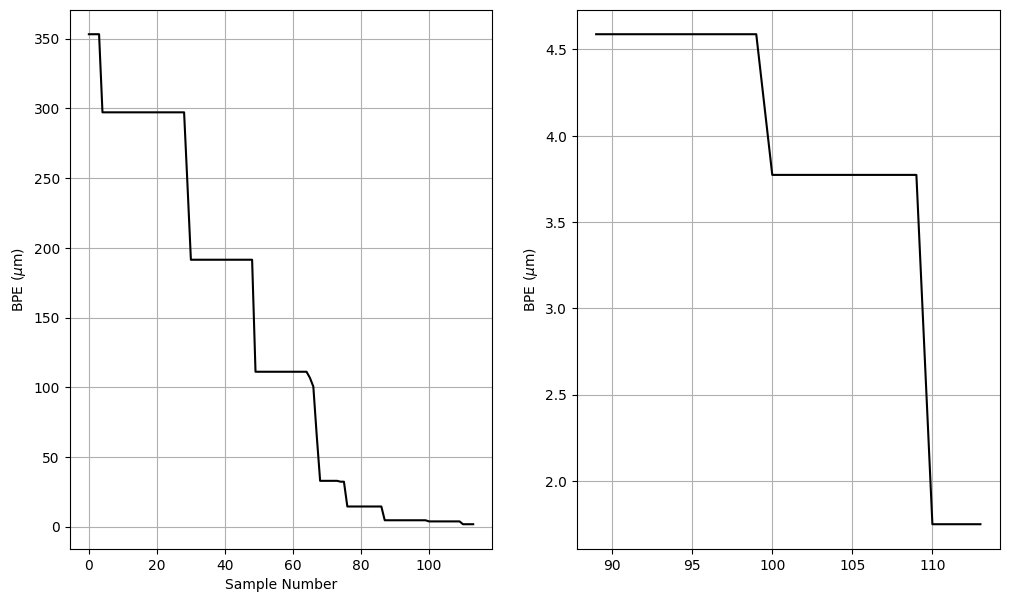

In [88]:
y1 = X.generator.data["f"]/10
y1_mins = np.minimum.accumulate(y1)


idx = np.arange(len(y1_mins))
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
ax0.plot(idx, y1_mins,'k')
ax0.grid()
ax0.set_xlabel("Sample Number")
ax0.set_ylabel("BPE ($\mu$m)")

ax1.plot(idx[-25:], y1_mins[-25:],'k')
ax1.grid()
ax1.set_ylabel("BPE ($\mu$m)");